# Failure Analysis

## Imports

### Packages

In [1]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision import models
import pandas as pd
import numpy as np
import sys
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, roc_curve, auc
import random

### Local

In [2]:
sys.path.append(".")
sys.path.append("..")
from dataset.patient_dataset import PatientDataset
from models.lstm import LSTM
from models.omnipotent_resnet import Net
from models.combined_net import CombinedNet
from visualisation.slice_plotter import plot_patient_slices
from visualisation.analysis_plotter import plot_confusion_matrix, plot_roc_curve

## Parameters

In [3]:
### DEFAULT PARAMETERS ###
### Data parameters ###
DATA_DIR = '../../../data/sliced-data/train'  # The slices we will train on for each patient
DS_DIR = '../../../data/data-split'
TARGET_SLICES = (0, 32)
### Model parameters ###
MODEL_DIR = '../../../models'  # Directory where best models are saved
TRAINED_MODEL = 'lstm_008.pt'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'  # Train on GPU or CPU
RESNET_MODEL_TYPE = 'resnet34'  # Which type of resnet is used by the model
### Test parameters ###
N_FEATURES = 128
BATCH_SIZE = 1

## Load Model

In [4]:
model = models.resnet34()
resnet = Net(model, 'combinednet', N_FEATURES)
lstm_net = LSTM(n_features=N_FEATURES, n_hidden=64, n_layers=2)
combined_net = CombinedNet(name='combinednet', cnn_net=resnet, lstm_net=lstm_net)
combined_net.load_state_dict(torch.load(os.path.join(MODEL_DIR, TRAINED_MODEL)))
combined_net.to(DEVICE)
print("Loaded "+TRAINED_MODEL)

Loaded lstm_008.pt


## Load Data

In [5]:
val_df = pd.read_csv(os.path.join(DS_DIR, "train_df.csv"), names=["patient_nr", "slice_nr", "class"])
print(f"\nNumber of unique patient numbers in validation set: {len(np.unique(val_df['patient_nr']))}")
print(f"Number of unique slice numbers in validation set:   {len(np.unique(val_df['slice_nr']))}")
print(f"Number of unique class values in validation set:    {len(np.unique(val_df['class']))}")
    
val_patients = pd.read_csv(os.path.join(DS_DIR, "train_patients.csv"), names=["patient_nr"]).to_numpy().flatten()
print(f"Number of patient numbers in the validation patients list: {len(val_patients)}")


Number of unique patient numbers in validation set: 18
Number of unique slice numbers in validation set:   32
Number of unique class values in validation set:    2
Number of patient numbers in the validation patients list: 18


In [6]:
print(val_df)

     patient_nr  slice_nr  class
0           239         0   True
1           239         1   True
2           239         2   True
3           239         3   True
4           239         4   True
..          ...       ...    ...
635         670        27  False
636         670        28  False
637         670        29  False
638         670        30  False
639         670        31  False

[576 rows x 3 columns]


##  Dataloader

In [7]:
analysis_set = PatientDataset(val_df, val_patients, TARGET_SLICES, DATA_DIR)
analysis_loader = data.DataLoader(analysis_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())

## Test Model

In [8]:
combined_net.eval()
false_positives = []
false_negatives = []
probabilities = []
predictions = []
targets = []
    
for batch_idx, (image, target) in tqdm(enumerate(analysis_loader), total=len(analysis_loader), desc="#analysis_batches", leave=False):
    image = image.float().to(DEVICE)
    target = target.int().detach().cpu().data.numpy()[0]
    output = combined_net(image).detach().cpu()
    image = np.squeeze(image.detach().cpu().data.numpy())
    
    # Compute probabilities (requirement: round to 5 decimals)
    probability = np.round(torch.sigmoid(output).numpy(), 5)
    
    # Compute class from probability (>0.5 = abnormal)
    prediction = (probability > 0.5).astype(np.uint8)
    
    # Save probability, predicted and target values
    probabilities.append(probability)
    predictions.append(prediction)
    targets.append(target)
    
    # Save wrongly predicted images
    if((target == 0) & (prediction == 1)):
        false_positives.append(image)
        
    if((target == 1) & (prediction == 0)):
        false_negatives.append(image)

## Confusion Matrix

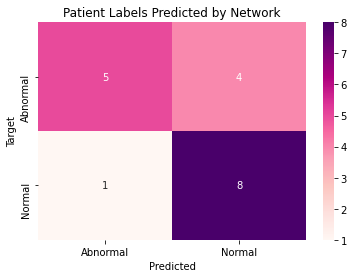

In [9]:
plot_confusion_matrix(targets, predictions)

In [10]:
tn, fp, fn, tp = confusion_matrix(targets, predictions).ravel()

In [11]:
print("True Positives: "+str(tp))
print("True Negatives: "+str(tn))
print("False Positives: "+str(fp))
print("False Negatives: "+str(fn))

True Positives: 8
True Negatives: 5
False Positives: 4
False Negatives: 1


## Classification Metrics

In [12]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print("Accuracy: {:.2f}".format(accuracy))
print("Sensitivity: {:.2f}".format(sensitivity))
print("Specificity: {:.2f}".format(specificity))

Accuracy: 0.72
Sensitivity: 0.89
Specificity: 0.56


## ROC-curve & AUC 

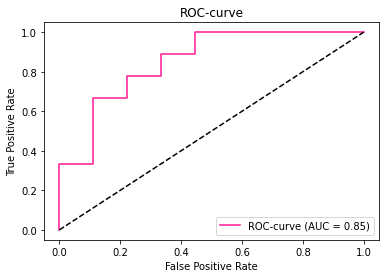

In [13]:
fpr, tpr, thresholds = roc_curve(targets, probabilities)
roc_auc = auc(fpr, tpr)
plot_roc_curve(fpr, tpr, roc_auc)

## Plot Images

### False Positive Patient
Normal patient labeled as an abnormal patient.

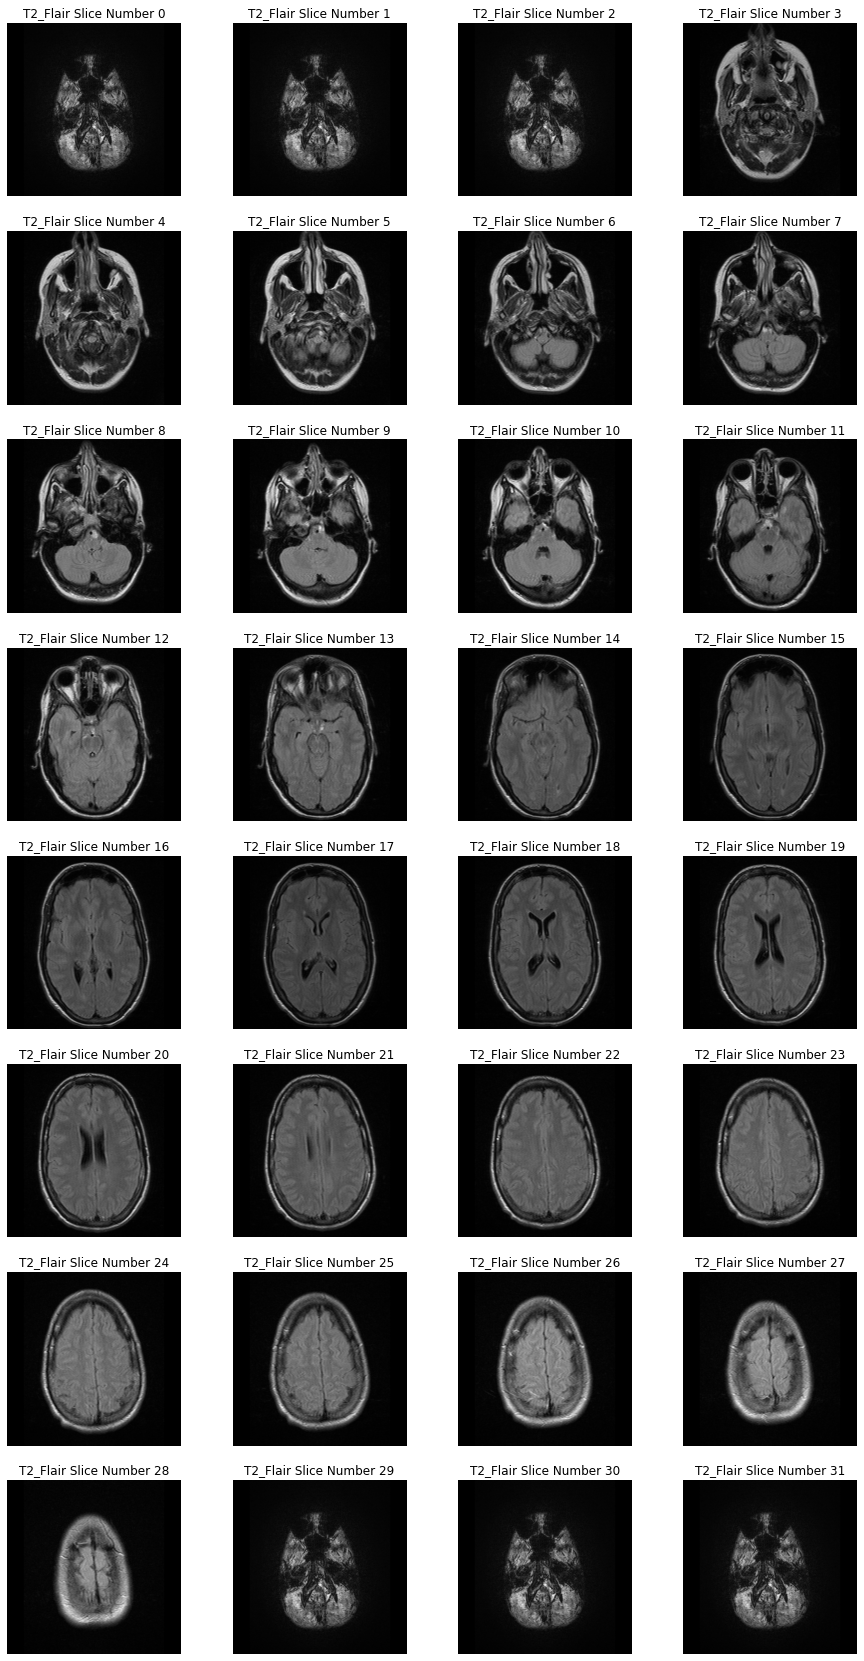

In [14]:
fp_patient = random.choice(false_positives)
plot_patient_slices(fp_patient)

### False Negative Patient
Abnormal patient labeled as a normal patient.

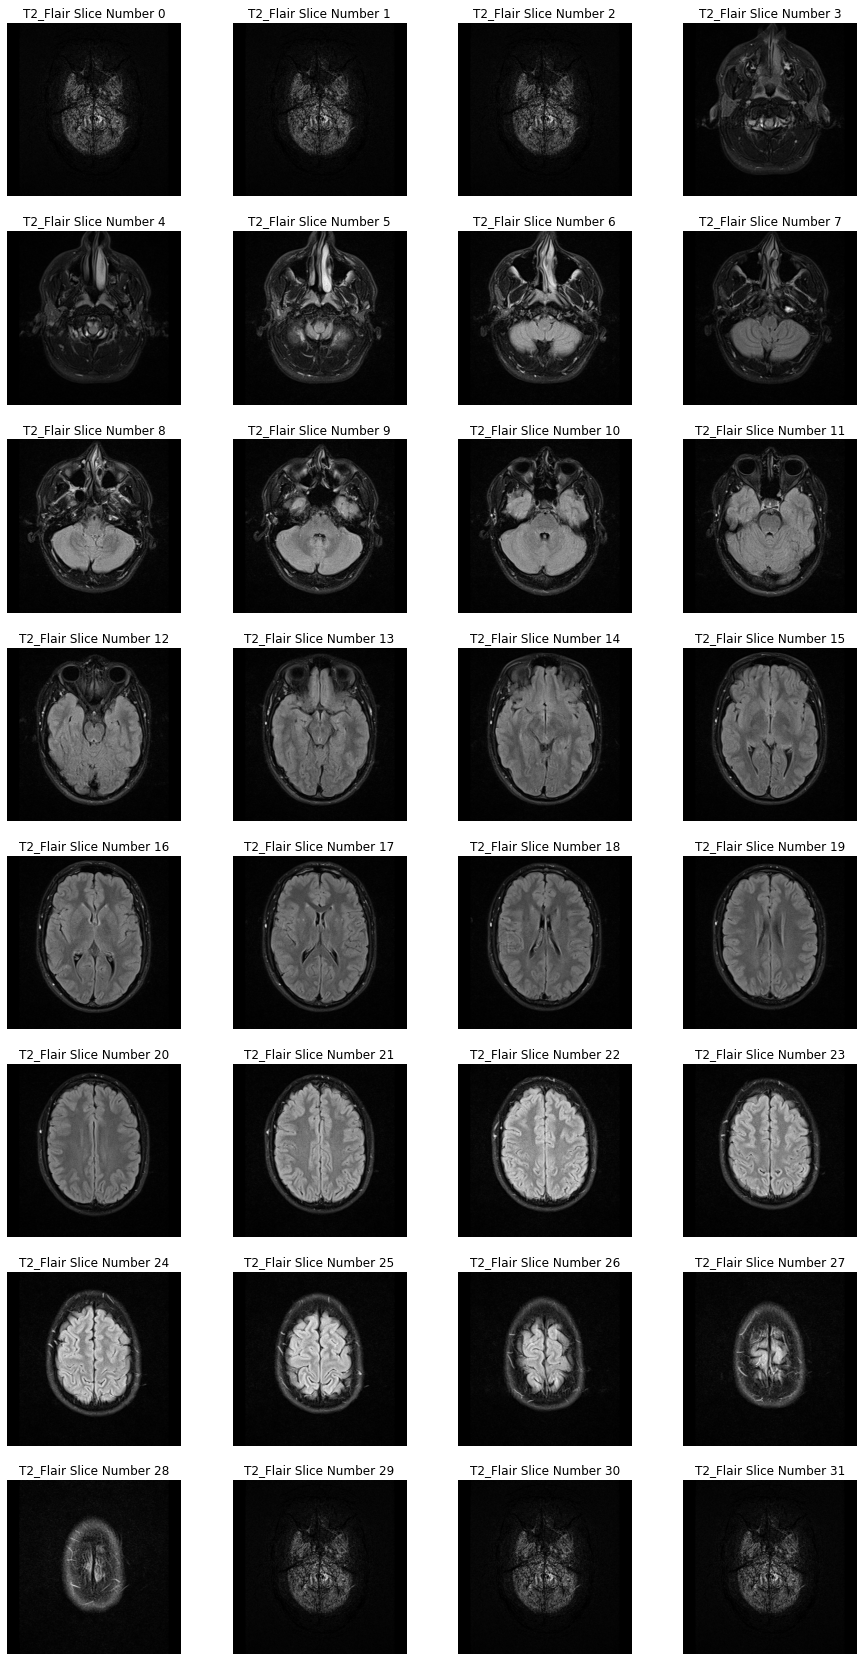

In [15]:
fn_patient = random.choice(false_negatives)
plot_patient_slices(fn_patient)